![Image of Yaktocat](https://oepfelbaum.com/wp_live/wp-content/themes/appletree/dist/img/logo-main_ed18093c87353e6715bcc40c699c37f9.png)

# Oe LuKB Market Risk - Jupyter Notebook

**Author**: Fabian Arter, David Gerber <br>
**Date**: `2022-01-29` - `2022-05-10`

The aim of this notebook is the explain the main concepts of market risk.

## Volatility & Return Distribution

### Set Input Data


<div class="alert alert-block alert-info">
<b>Input:</b> Please choose here for which titles you would like to see historical data. 
</div>



   Check **Yahoo Finance** for all tickers: [https://finance.yahoo.com](https://finance.yahoo.com/lookup) 

Enter in the below `data.frame` the desired tickers (incl. a friendly name, which can be chosen by you)

In [166]:
#input.tickers.df = data.frame(ticker=c("LUKN.SW","BTC-USD","ROG.SW"),
#                              friendly.name=c("LUKN.SW","Bitcoin (USD)","Roche"))


input.tickers.df = data.frame(ticker=c("ROG.SW", 
                                       "NESN.SW", 
                                       "NOVN.SW", 
                                       "^SSMI",
                                       "TSLA")
                                    ,
                               friendly.name=c("Roche", 
                                               "Nestle", 
                                               "Novartis", 
                                               "SMI",
                                               "Tesla")
                              )


<div class="alert alert-block alert-info">
<b>Input:</b> Please choose here the start and end date of the historical price data. Also specify length of rolling periods - make sure data history is large enough!
</div>



In [167]:
start.date = as.Date("2018-01-01")
last.date  = Sys.Date() # today 
n.days.rolling=c(60,120,250,500) # specify length of rolling periods - make sure data history is large enough

In [168]:
print(input.tickers.df)
message(paste("start date:",start.date))
message(paste("last date: ",last.date))
message("Rolling Periods in Days: ")
cat(n.days.rolling)

   ticker friendly.name
1  ROG.SW         Roche
2 NESN.SW        Nestle
3 NOVN.SW      Novartis
4   ^SSMI           SMI
5    TSLA         Tesla
6    ^NDX        Nasdaq


start date: 2018-01-01

last date:  2022-05-27

Rolling Periods in Days: 



60 120 250 500

### Installing and loading R packages

In [169]:
library(ggplot2)
library(reshape2)
library(dplyr)

### Loading Historical End of Day Data from Yahoo Finance

In [170]:
get_log_returns <- function(ticker_symbol, friendly_name, from, to) {
    curl::curl_download(sprintf('https://query1.finance.yahoo.com/v7/finance/download/%s?period1=%s&period2=%s&interval=1d&events=history&crumb=XXXXXXX', ticker_symbol, as.numeric(as.POSIXct(from)), as.numeric(as.POSIXct(to))), sprintf("%s.csv", ticker_symbol))
    data <- read.csv(sprintf("%s.csv", ticker_symbol))
    adj_close <- suppressWarnings(as.numeric(data$Adj.Close))
    is_na = is.na(adj_close)
    adj_close <- adj_close[!is_na]
    date <- data$Date[!is_na]
    
    log_returns <- log(adj_close/dplyr::lag(adj_close))
    df <- data.frame(date, friendly_name, adj_close, log_returns)
    return(df)
}

PF.daily.return.long <- data.frame(ref.date=character(),
                 friendly.name=character(), 
                 price.adjusted=character(), 
                 daily.return=character()) 


for(i in 1:nrow(input.tickers.df)) {       # for-loop over rows
  PF.daily.return.long <- rbind(PF.daily.return.long, get_log_returns(input.tickers.df[i,1], input.tickers.df[i,2], start.date, last.date))
}

colnames(PF.daily.return.long) <- c("ref.date","friendly.name","price.adjusted","daily.return")
PF.daily.return.long[is.na(PF.daily.return.long$daily.return),]$daily.return <- 0

In [171]:
#PF.daily.return.long <- read.csv("PF_daily_return_long.csv")
nrow(PF.daily.return.long)

print(paste("chosen tickers:",paste(input.tickers.df$friendly.name,collapse=", ")))
PF.daily.return.long <- PF.daily.return.long[PF.daily.return.long$friendly.name %in% input.tickers.df$friendly.name,]
PF.daily.return.long <- PF.daily.return.long[as.Date(PF.daily.return.long$ref.date) >= start.date &
                                             as.Date(PF.daily.return.long$ref.date) <= last.date,]


nrow(PF.daily.return.long)

PF.daily.return.long$friendly.name <- as.character(PF.daily.return.long$friendly.name)
PF.daily.return.long$ref.date      <- as.Date(PF.daily.return.long$ref.date)

[1] 6627

[1] "chosen tickers: Roche, Nestle, Novartis, SMI, Tesla, Nasdaq"


[1] 6627

### Historical Returns Normalized

In [172]:
# Cumulated return plot
#ggplot(PF.daily.cumul.long, aes(y=cumul.return, x=ref.date, color=name)) + geom_line(size=0.3)  

### Daily Returns

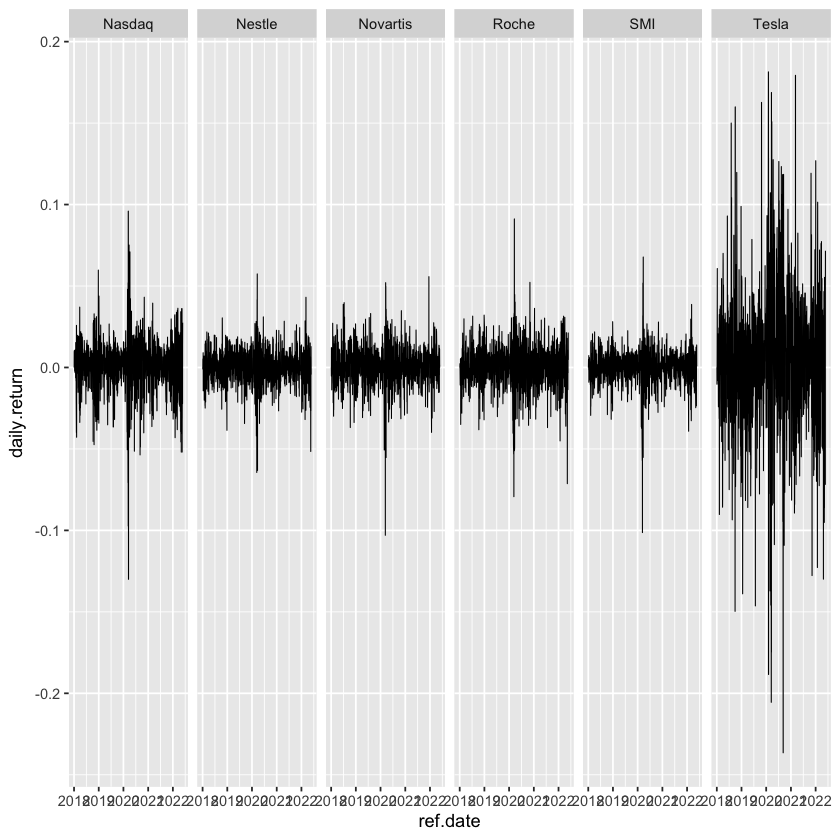

In [173]:
# return plot
ggplot(PF.daily.return.long, aes(y=daily.return, x=ref.date)) + geom_line(size=0.3)  + facet_grid(~ friendly.name)
 

### Histogram of Daily Returns

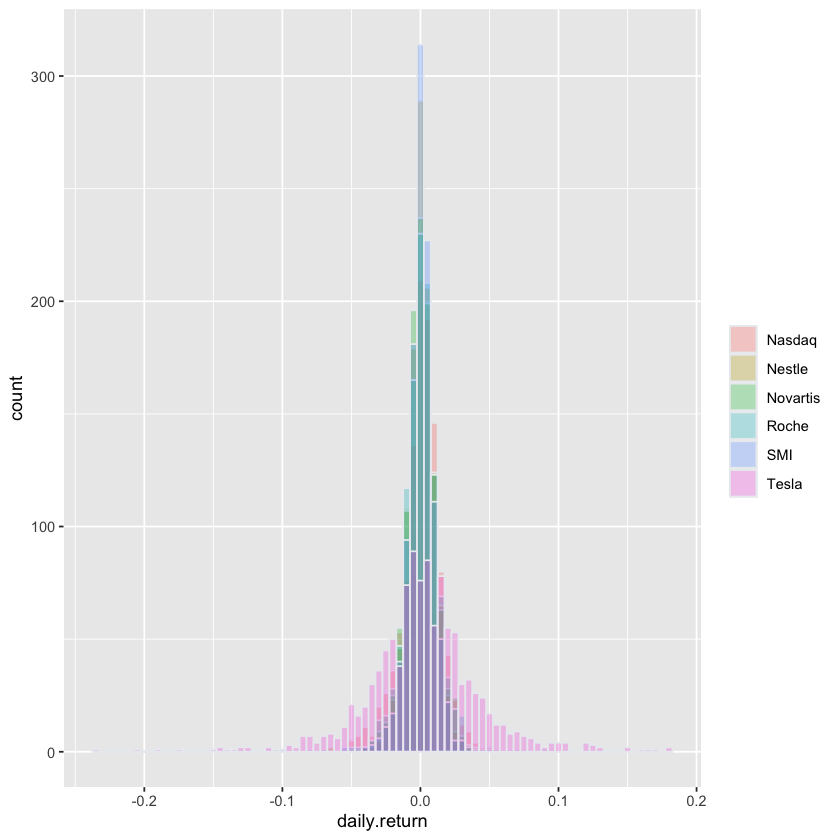

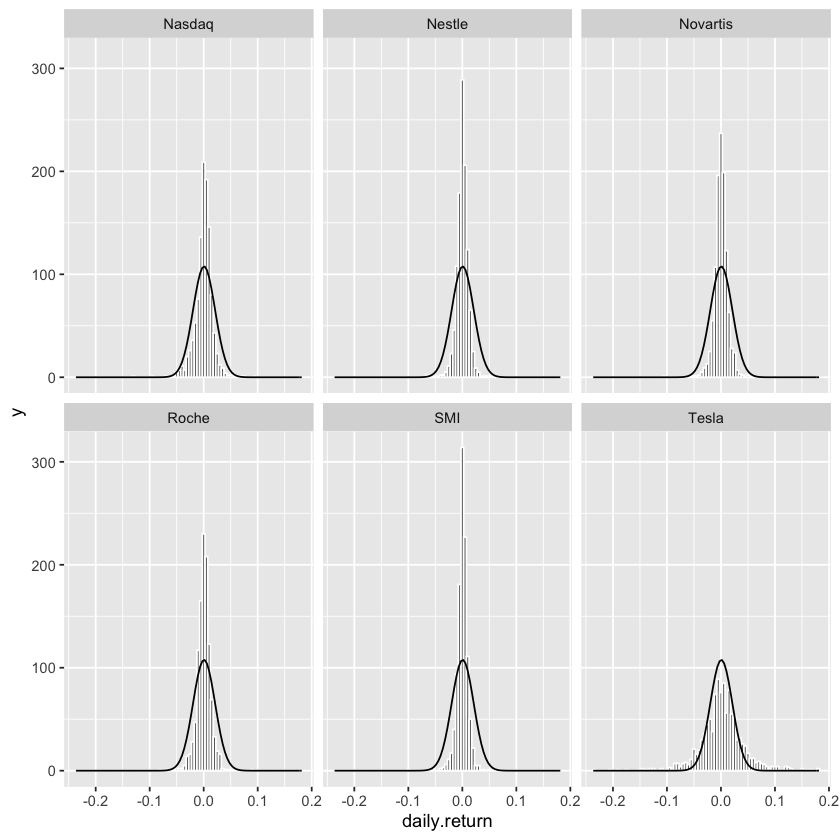

In [174]:
binwidth.set = 0.005
stocks.count = nrow(input.tickers.df)

ggplot(PF.daily.return.long, aes(x=daily.return, fill=friendly.name,binwidth = binwidth.set)) +
    geom_histogram( color="#e9ecef", alpha=0.3, position = 'identity',binwidth = binwidth.set) +
    labs(fill="")

ggplot(PF.daily.return.long, aes(x=daily.return, binwidth = binwidth.set)) +
    geom_histogram( color="#e9ecef", alpha=0.3, position = 'identity',binwidth = binwidth.set) +
    labs(fill="") + facet_wrap(~friendly.name) + 
    geom_histogram(colour = "white", binwidth = binwidth.set) +
stat_function(fun = function(x) dnorm(x, mean = mean(PF.daily.return.long$daily.return), sd = sd(PF.daily.return.long$daily.return)) * nrow(PF.daily.return.long)/stocks.count * binwidth.set) 

### Statistics: Daily Retun Percentiles & Check for Normality
**Shapiro-Wilk Test for Normality** 
Null hypothesis: The data is normally distributed. If p> 0.05, normality can be assumed

In [175]:
 
PF.daily.return.long %>% group_by(friendly.name) %>% 
  summarise(min = min(daily.return)
            ,max = max(daily.return)
            ,mean = mean(daily.return)
            ,sd = sd(daily.return)
            ,n = n()
            ,q05 = quantile(daily.return, .05)
            ,q01 = quantile(daily.return, .01)
            ,q95 = quantile(daily.return, .95)
            ,q99 = quantile(daily.return, .99)
            ,shapiro.normality.pvalue = as.numeric(shapiro.test(daily.return)[2])
            ) 



friendly.name,min,max,mean,sd,n,q05,q01,q95,q99,shapiro.normality.pvalue
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Nasdaq,-0.13003151,0.09596639,0.0005718352,0.01631832,1109,-0.02697534,-0.04533661,0.02267011,0.04037486,9.782823e-24
Nestle,-0.06444845,0.05742948,0.0004037196,0.01041702,1105,-0.01630440,-0.02843866,0.01613744,0.02481382,4.290945e-18
Novartis,-0.10299928,0.05575005,0.0003316303,0.01203128,1105,-0.01785624,-0.03150148,0.01912012,0.02965361,2.088374e-19
Roche,-0.07929968,0.09119599,0.0003967127,0.01291804,1105,-0.01909608,-0.03591540,0.02003213,0.03102090,2.938556e-19
SMI,-0.10133930,0.06780465,0.0001760177,0.01026673,1094,-0.01582643,-0.02941704,0.01440672,0.02310752,3.291468e-26
Tesla,-0.23651792,0.18144503,0.0021654866,0.04137770,1109,-0.06015014,-0.12343616,0.06832309,0.12302448,3.078392e-20


### QQ Plots

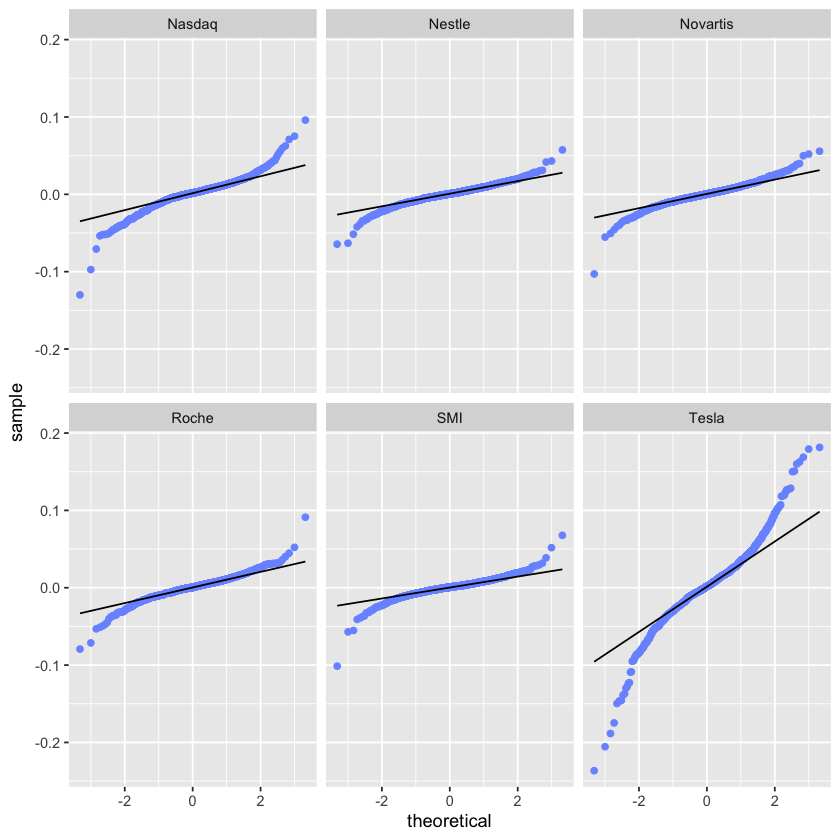

In [176]:
ggplot(PF.daily.return.long) +
    stat_qq(aes(sample=daily.return),colour = "#7997FF") + 
    stat_qq_line(aes(sample = daily.return)) + xlab("theoretical") + ylab("sample") +
   facet_wrap(~friendly.name)  

## Volatility

### Unweighted Historical Volatility

In [177]:

rollingVolaSingleTicker <- function(PF.daily.return.long, n.days.rolling=120) {
  
  n.days.total <- nrow(PF.daily.return.long)
  n.rows       <- n.days.total-n.days.rolling
  
  rolling.vola.data.result <- data.frame(ref.date         = rep(as.Date(NA),n.rows),
                                         start.date       = rep(as.Date(NA),n.rows),       
                                         friendly.name    = rep(NA,n.rows),
                                         estimator        = rep(NA,n.rows),
                                         type             = rep("vola",n.rows),
                                         method           = "simple - rolling",
                                         n.days.rolling   = rep(n.days.rolling, n.rows),
                                         n.observations   = rep(NA, n.rows))
  
                                  
  for (j in 1:n.rows) {
   # print(j)
    rolling.vola.data.result$ref.date[j]        <- PF.daily.return.long$ref.date[(n.days.rolling+j)]
    rolling.vola.data.result$start.date[j]      <- PF.daily.return.long$ref.date[(j)]
    rolling.vola.data.result$friendly.name[j]   <- as.character(PF.daily.return.long$friendly.name[(n.days.rolling+j)])
    rolling.vola.data.result$estimator[j]       <- sd(PF.daily.return.long$daily.return[j:(n.days.rolling+j)])
    rolling.vola.data.result$n.observations[j]  <- length(PF.daily.return.long$daily.return[j:(n.days.rolling+j)])
    
  }
  return(rolling.vola.data.result)
}


rollingCorrelTwoTicker <- function(PF.daily.return.long,X1="ticker1 friendly name",X2="ticker2 friendly name", n.days.rolling=120) {
  
  PF.daily.return.long3 <- PF.daily.return.long[PF.daily.return.long$friendly.name %in% c(X1,X2),]
  PF.daily.return.long3$friendly.name <- as.character(PF.daily.return.long3$friendly.name)
    
  #long to wide
  PF.daily.return.wide.correl <- reshape2::dcast(PF.daily.return.long3,  ref.date ~ friendly.name, value.var = "daily.return", fill=0)
  colnames(PF.daily.return.wide.correl) <- c("ref.date","X1","X2")
    

  n.days.total <- nrow(PF.daily.return.wide.correl)
  n.rows       <- n.days.total-n.days.rolling
  
  rolling.correl.data.result <- data.frame(ref.date       = rep(as.Date(NA),n.rows),
                                  start.date       = rep(as.Date(NA),n.rows),   
                                  friendly.name    = rep(paste(as.character(X1)," - ",as.character(X2)),n.rows),
                                  estimator        = rep(NA,n.rows),
                                  type             = rep("correl",n.rows),
                                  method           = rep("correl - rolling",n.rows),
                                  n.days.rolling   = rep(n.days.rolling, n.rows),
                                  n.observations   = rep(NA, n.rows))
  
  for (j in 1:n.rows) {
  #   print(j)
  #   print(paste(PF.daily.return.wide.correl$ref.date[j],"-",PF.daily.return.wide.correl$ref.date[n.days.rolling+j]))
    rolling.correl.data.result$start.date[j]   <- PF.daily.return.wide.correl$ref.date[j]
    rolling.correl.data.result$ref.date[j]     <- PF.daily.return.wide.correl$ref.date[(n.days.rolling+j-1)]
    rolling.correl.data.result$estimator[j] <- cor(PF.daily.return.wide.correl$X1[j:(n.days.rolling+j-1)],
                                            PF.daily.return.wide.correl$X2[j:(n.days.rolling+j-1)])
    rolling.correl.data.result$n.observations[j]  <- length(c(PF.daily.return.wide.correl$X1[j:(n.days.rolling+j-1)],
                                                  PF.daily.return.wide.correl$X2[j:(n.days.rolling+j-1)]))
    
  }
  return(rolling.correl.data.result)
}

rollingSDandCorrel <- function(PF.daily.return.long, n.days.rolling=c(60,120,250,500)) {
  
tickers <- unique(PF.daily.return.long$friendly.name)
#######################################
# Rolling Vola for each ticker

input.table.vola <- data.frame(ticker=rep(tickers,each=length(n.days.rolling)), n.days.rolling = n.days.rolling)
message("INPUT TABLE VOLATILITY")
print(input.table.vola)
rolling.vola.list <- vector("list", length= nrow(input.table.vola))
  
## RUN ALL VOLA Combinations
  for(i in 1:nrow(input.table.vola)) {
   # print(paste("Run:",i))
    PF.daily.return.single <- PF.daily.return.long[PF.daily.return.long$friendly.name==input.table.vola$ticker[i],]
    
    rolling.vola.list[[i]] <-  rollingVolaSingleTicker(PF.daily.return.single, n.days.rolling = input.table.vola$n.days.rolling[i])
  }
  
  rolling.vola.data.result.long <- plyr::rbind.fill(rolling.vola.list)
  
  #######################################
  # Rolling Correl for each pair
  
  if(length(tickers)>1) {
  
  correl.comb.table <- (t(combn(tickers,2)))
  
  input.table.correl <- data.frame(X1=correl.comb.table[,1],
                                   X2=correl.comb.table[,2],
                                   n.days.rolling = rep(n.days.rolling,each=nrow(correl.comb.table)))
  
  message("INPUT TABLE CORREL")
  print(input.table.correl)
  rolling.correl.list <- vector("list", length= nrow(input.table.correl))
  
  for(i in 1:nrow(input.table.correl)) {
    

    rolling.correl.list[[i]] <-  rollingCorrelTwoTicker(PF.daily.return.long,
                                               X1 = as.character(input.table.correl$X1[i]),
                                               X2 = as.character(input.table.correl$X2[i]), 
                                               n.days.rolling = input.table.correl$n.days.rolling[i])
    #print(paste(i, "...",input.table.correl[i,]))  
  }
  
  rolling.correl.data.result.long <- plyr::rbind.fill(rolling.correl.list)
  
  rolling.vola.correl.result.table <- rbind(rolling.vola.data.result.long, rolling.correl.data.result.long)
  
  } else {
    rolling.vola.correl.result.table <- rolling.vola.data.result.long
  }
  
  return(rolling.vola.correl.result.table)
}



#### Run Rolling Periods for Vola and Correl

In [178]:
rolling.vola.correl.result.table <- rollingSDandCorrel(PF.daily.return.long, n.days.rolling)


INPUT TABLE VOLATILITY



     ticker n.days.rolling
1     Roche             60
2     Roche            120
3     Roche            250
4     Roche            500
5    Nestle             60
6    Nestle            120
7    Nestle            250
8    Nestle            500
9  Novartis             60
10 Novartis            120
11 Novartis            250
12 Novartis            500
13      SMI             60
14      SMI            120
15      SMI            250
16      SMI            500
17    Tesla             60
18    Tesla            120
19    Tesla            250
20    Tesla            500
21   Nasdaq             60
22   Nasdaq            120
23   Nasdaq            250
24   Nasdaq            500


INPUT TABLE CORREL



         X1       X2 n.days.rolling
1     Roche   Nestle             60
2     Roche Novartis             60
3     Roche      SMI             60
4     Roche    Tesla             60
5     Roche   Nasdaq             60
6    Nestle Novartis             60
7    Nestle      SMI             60
8    Nestle    Tesla             60
9    Nestle   Nasdaq             60
10 Novartis      SMI             60
11 Novartis    Tesla             60
12 Novartis   Nasdaq             60
13      SMI    Tesla             60
14      SMI   Nasdaq             60
15    Tesla   Nasdaq             60
16    Roche   Nestle            120
17    Roche Novartis            120
18    Roche      SMI            120
19    Roche    Tesla            120
20    Roche   Nasdaq            120
21   Nestle Novartis            120
22   Nestle      SMI            120
23   Nestle    Tesla            120
24   Nestle   Nasdaq            120
25 Novartis      SMI            120
26 Novartis    Tesla            120
27 Novartis   Nasdaq        

### Plot: Annualized Volatility by Ticker and Rolling Period

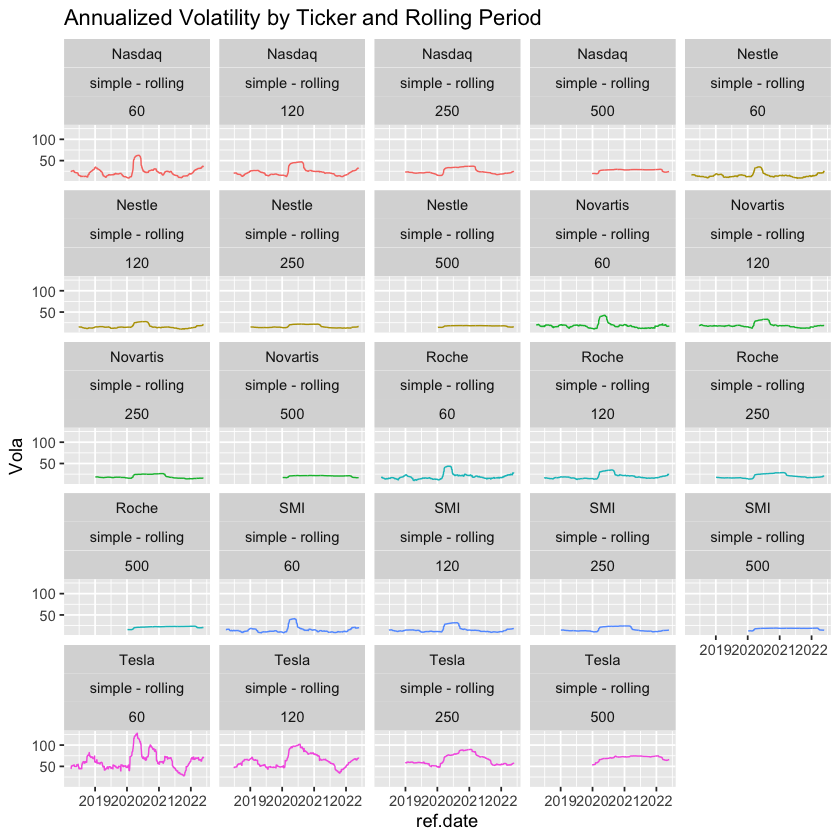

In [179]:
# PLOT VOLA per Ticker, Rolling Period
ggplot(rolling.vola.correl.result.table[rolling.vola.correl.result.table$type=="vola",], aes(y=estimator*sqrt(250)*100, x=ref.date, colour=friendly.name)) + 
  geom_line(size=0.4 ) + ylab("Vola") + ggtitle("Annualized Volatility by Ticker and Rolling Period") + 
  scale_x_date(date_breaks = "1 year", date_labels = "%Y") + 
  theme(legend.position="none") +
  facet_wrap(vars(friendly.name,method,n.days.rolling))   

### Plot: Annualized Volatility by Rolling Period

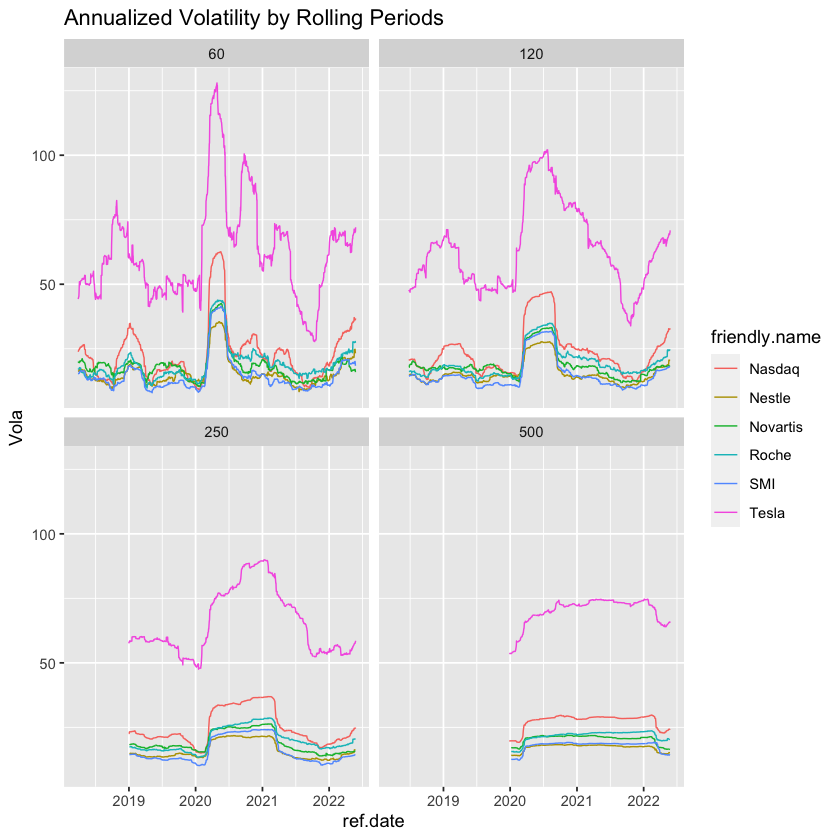

In [180]:
# PLOT VOLA per Rolling Period
ggplot(rolling.vola.correl.result.table[rolling.vola.correl.result.table$type=="vola",], aes(y=estimator*sqrt(250)*100, x=ref.date, colour=friendly.name)) + 
  geom_line(size=0.4 ) + ylab("Vola") + ggtitle("Annualized Volatility by Rolling Periods") + 
  scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
  facet_wrap(vars(n.days.rolling))  

## Correlation

### Plot: Correlation by Tickers and Rolling Period

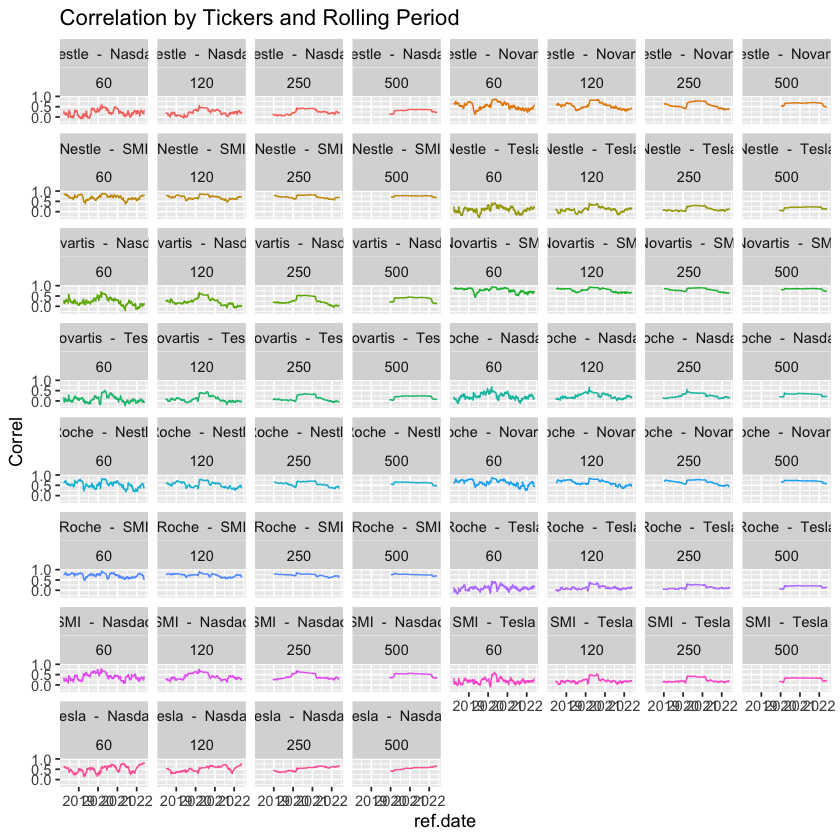

In [181]:
# PLOT CORREL per Ticker, Rolling Period
ggplot(rolling.vola.correl.result.table[rolling.vola.correl.result.table$type=="correl",], aes(y=estimator, x=ref.date, colour=friendly.name)) + 
  geom_line(size=0.4 ) + ylab("Correl") + ggtitle("Correlation by Tickers and Rolling Period") + 
  theme(legend.position="none") +
  facet_wrap(vars(friendly.name,n.days.rolling))   


### Plot: Correlation by Rolling Period

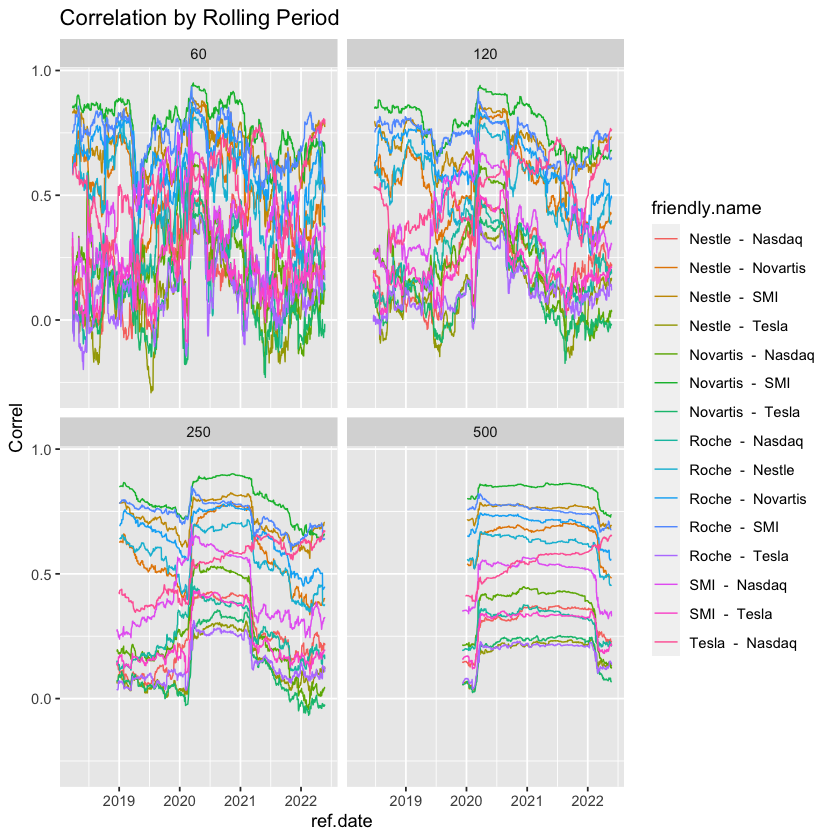

In [182]:
# PLOT CORREL per Ticker, Rolling Period
ggplot(rolling.vola.correl.result.table[rolling.vola.correl.result.table$type=="correl",], aes(y=estimator, x=ref.date, colour=friendly.name)) + 
  geom_line(size=0.4 ) + ylab("Correl") + ggtitle("Correlation by Rolling Period") + 
  facet_wrap(vars(n.days.rolling))   